

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## 获取数据

首先引入需要的包。

In [1]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from nltk.corpus import stopwords
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 

base_path = os.path.abspath('/tf/eipi10/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# 设置GPU内存自动扩增
qtf.utils.set_gpu_memory_growth()
nltk.download('stopwords')

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

初始化参数。

In [3]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=15,
    # randomly shift images horizontally
    width_shift_range=0.05,
    # randomly shift images vertically
    height_shift_range=0.05,
    # randomly flip images
    horizontal_flip=False,
    # randomly flip images
    vertical_flip=False
)    


output_path = os.path.abspath('./output')
data_name = 'mnist'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

params = {
    'data_name': data_name,
    'data_path': data_path,
    'use_data_augmentation': True,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(60000/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.1, 'layer_count':1, 'units':128, 'epochs':120},
        'lenet':{'dropout':0.2, 'epochs':120},
        'custom':{'dropout':0.2, 'epochs':120},
        'vgg':{'dropout':0.3, 'epochs':120},
        'resnet':{'epochs':120}        
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

2021-08-10 14:41:15,335: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/results.json


### 下载数据

开始下载数据。

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

train_images = train_images/255.0   
test_images = test_images/255.0   

# 增加一个通道
train_images = np.expand_dims(train_images, axis=-1) 
test_images = np.expand_dims(test_images, axis=-1) 


print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)


(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)




### 查看数据

下面看一看实际的数据是啥样的。

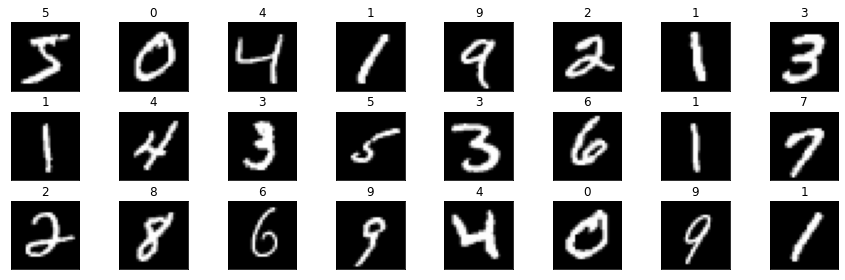

In [5]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 类别分布

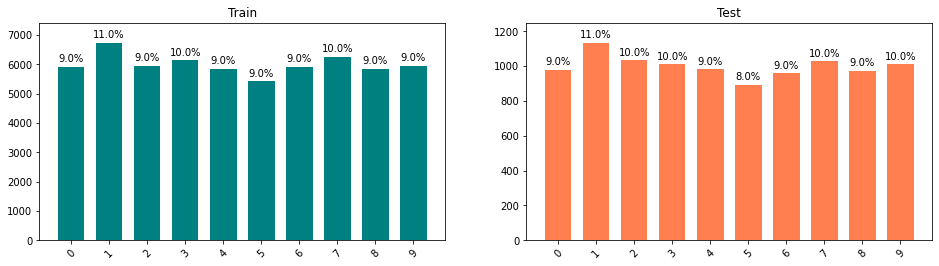

In [6]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## 准备数据

不同的模型需要准备不同的数据，所以确定一下要构建哪种模型。

### 原始数据


In [7]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [8]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [9]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 28, 28, 1), dtype=tf.float64, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

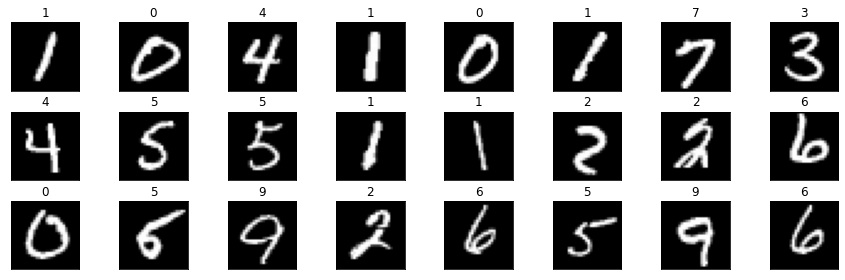

In [10]:
qtf.utils.show_images(sample_images, sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 数据增强

In [11]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

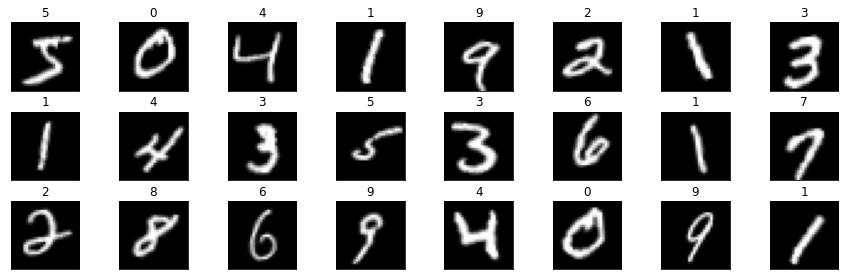

In [12]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

看看图片原始的样子

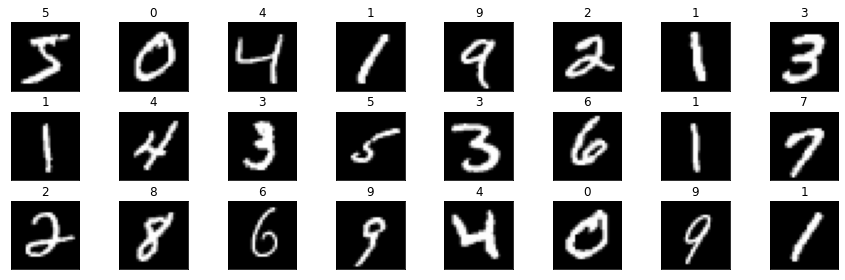

In [13]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

设置随机生成训练数据batch

In [14]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [15]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = True


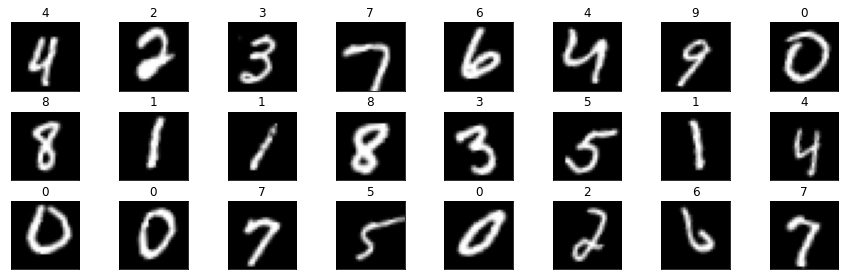

In [16]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  模型

### MLP

2021-08-10 14:41:25,866: INFO: model_params.mlp1.dropout=0.1
2021-08-10 14:41:25,867: INFO: model_params.mlp1.layer_count=1
2021-08-10 14:41:25,868: INFO: model_params.mlp1.units=128
2021-08-10 14:41:25,925: INFO: learning_rate=0.001
2021-08-10 14:41:25,926: INFO: model_params.mlp1.clip_value=None
2021-08-10 14:41:25,945: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1
2021-08-10 14:41:25,948: INFO: model_params.mlp1.epochs=120
2021-08-10 14:41:25,949: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1, monitor=val_accuracy)
2021-08-10 14:41:25,949: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 14:41:25,950: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 14:41:25,951: INFO: use LearningRateScheduler()
2021-08-10 14:41:25,

Model: "mlp1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.4399 - accuracy: 0.8687 - val_loss: 0.134

2021-08-10 14:41:50,072: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


Epoch 2/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.2109 - accuracy: 0.9367 - val_loss: 0.1003 - val_accuracy: 0.9698
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


2021-08-10 14:42:12,960: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


Epoch 3/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.1657 - accuracy: 0.9497 - val_loss: 0.0736 - val_accuracy: 0.9762
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


2021-08-10 14:42:35,884: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


Epoch 4/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.1469 - accuracy: 0.9558 - val_loss: 0.0727 - val_accuracy: 0.9779
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


2021-08-10 14:42:58,565: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


Epoch 5/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.1355 - accuracy: 0.9592 - val_loss: 0.0618 - val_accuracy: 0.9809
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


2021-08-10 14:43:21,726: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


Epoch 6/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.1271 - accuracy: 0.9609 - val_loss: 0.0566 - val_accuracy: 0.9821
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


2021-08-10 14:43:44,705: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


Epoch 7/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.1199 - accuracy: 0.9635 - val_loss: 0.0582 - val_accuracy: 0.9801
Epoch 8/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.1146 - accuracy: 0.9646 - val_loss: 0.0578 - val_accuracy: 0.9813
Epoch 9/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.1104 - accuracy: 0.9661 - val_loss: 0.0555 - val_accuracy: 0.9831
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


2021-08-10 14:44:51,855: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


Epoch 10/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.1059 - accuracy: 0.9680 - val_loss: 0.0581 - val_accuracy: 0.9821
Epoch 11/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.1074 - accuracy: 0.9671 - val_loss: 0.0529 - val_accuracy: 0.9831
Epoch 12/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.1045 - accuracy: 0.9682 - val_loss: 0.0541 - val_accuracy: 0.9829
Epoch 13/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0996 - accuracy: 0.9704 - val_loss: 0.0515 - val_accuracy: 0.9831
Epoch 14/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0991 - accuracy: 0.9698 - val_loss: 0.0509 - val_accuracy: 0.9855
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


2021-08-10 14:46:42,542: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


Epoch 15/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0972 - accuracy: 0.9697 - val_loss: 0.0500 - val_accuracy: 0.9831
Epoch 16/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0957 - accuracy: 0.9712 - val_loss: 0.0464 - val_accuracy: 0.9856
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


2021-08-10 14:47:27,309: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


Epoch 17/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0948 - accuracy: 0.9707 - val_loss: 0.0517 - val_accuracy: 0.9842
Epoch 18/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0964 - accuracy: 0.9712 - val_loss: 0.0487 - val_accuracy: 0.9840
Epoch 19/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0948 - accuracy: 0.9707 - val_loss: 0.0481 - val_accuracy: 0.9852
Epoch 20/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0889 - accuracy: 0.9730 - val_loss: 0.0515 - val_accuracy: 0.9836
Epoch 21/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0908 - accuracy: 0.9730 - val_loss: 0.0481 - val_accuracy: 0.9851
Epoch 22/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0907 - accuracy: 0.9727 - val_loss: 0.0544 - val_accuracy: 0.9828
Epoch 23/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0879 - accuracy: 0.9734 - val_

2021-08-10 14:50:24,043: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


Epoch 25/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0878 - accuracy: 0.9726 - val_loss: 0.0451 - val_accuracy: 0.9865
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


2021-08-10 14:50:46,660: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


Epoch 26/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0881 - accuracy: 0.9731 - val_loss: 0.0422 - val_accuracy: 0.9873
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


2021-08-10 14:51:09,488: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


Epoch 27/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0864 - accuracy: 0.9738 - val_loss: 0.0476 - val_accuracy: 0.9855
Epoch 28/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0867 - accuracy: 0.9736 - val_loss: 0.0481 - val_accuracy: 0.9862
Epoch 29/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0836 - accuracy: 0.9746 - val_loss: 0.0486 - val_accuracy: 0.9853
Epoch 30/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0826 - accuracy: 0.9748 - val_loss: 0.0470 - val_accuracy: 0.9855
Epoch 31/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0836 - accuracy: 0.9747 - val_loss: 0.0440 - val_accuracy: 0.9856
Epoch 32/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0796 - accuracy: 0.9750 - val_loss: 0.0441 - val_accuracy: 0.9856
Epoch 33/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0837 - accuracy: 0.9743 - val_

2021-08-10 14:55:55,679: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


Epoch 40/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0807 - accuracy: 0.9751 - val_loss: 0.0464 - val_accuracy: 0.9848
Epoch 41/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0764 - accuracy: 0.9769 - val_loss: 0.0507 - val_accuracy: 0.9852
Epoch 42/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0762 - accuracy: 0.9764 - val_loss: 0.0386 - val_accuracy: 0.9886
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


2021-08-10 14:57:02,345: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


Epoch 43/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0769 - accuracy: 0.9766 - val_loss: 0.0471 - val_accuracy: 0.9848
Epoch 44/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0773 - accuracy: 0.9765 - val_loss: 0.0436 - val_accuracy: 0.9867
Epoch 45/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0777 - accuracy: 0.9759 - val_loss: 0.0409 - val_accuracy: 0.9878
Epoch 46/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0787 - accuracy: 0.9758 - val_loss: 0.0427 - val_accuracy: 0.9873
Epoch 47/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0763 - accuracy: 0.9769 - val_loss: 0.0463 - val_accuracy: 0.9853
Epoch 48/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0773 - accuracy: 0.9764 - val_loss: 0.0467 - val_accuracy: 0.9862
Epoch 49/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0761 - accuracy: 0.9762 - val_

2021-08-10 15:06:14,427: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


Epoch 68/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0571 - accuracy: 0.9820 - val_loss: 0.0363 - val_accuracy: 0.9888
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


2021-08-10 15:06:37,116: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


Epoch 69/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0564 - accuracy: 0.9820 - val_loss: 0.0364 - val_accuracy: 0.9880
Epoch 70/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0554 - accuracy: 0.9823 - val_loss: 0.0357 - val_accuracy: 0.9885
Epoch 71/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0574 - accuracy: 0.9822 - val_loss: 0.0355 - val_accuracy: 0.9879
Epoch 72/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0560 - accuracy: 0.9832 - val_loss: 0.0358 - val_accuracy: 0.9882
Epoch 73/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0547 - accuracy: 0.9823 - val_loss: 0.0349 - val_accuracy: 0.9884
Epoch 74/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0554 - accuracy: 0.9829 - val_loss: 0.0363 - val_accuracy: 0.9881
Epoch 75/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0575 - accuracy: 0.9818 - val_

2021-08-10 15:10:39,801: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


Epoch 80/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0529 - accuracy: 0.9834 - val_loss: 0.0364 - val_accuracy: 0.9891
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


2021-08-10 15:11:02,483: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1/assets


Epoch 81/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0526 - accuracy: 0.9831 - val_loss: 0.0362 - val_accuracy: 0.9891
Epoch 82/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0549 - accuracy: 0.9827 - val_loss: 0.0364 - val_accuracy: 0.9891
Epoch 83/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0534 - accuracy: 0.9835 - val_loss: 0.0359 - val_accuracy: 0.9887
Epoch 84/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0555 - accuracy: 0.9832 - val_loss: 0.0354 - val_accuracy: 0.9890
Epoch 85/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0550 - accuracy: 0.9827 - val_loss: 0.0353 - val_accuracy: 0.9889
Epoch 86/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0549 - accuracy: 0.9830 - val_loss: 0.0365 - val_accuracy: 0.9888
Epoch 87/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0562 - accuracy: 0.9827 - val_

2021-08-10 15:26:07,788: INFO: finish training [elapsed time: 2681.84 seconds]


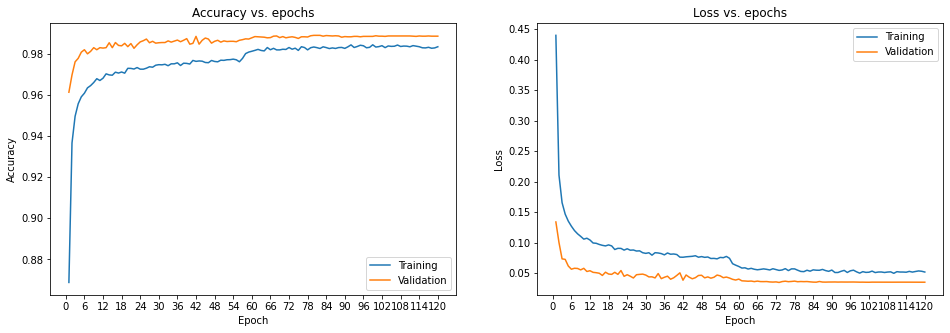

2021-08-10 15:26:08,335: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1
----------------------------------------evaluate----------------------------------------


2021-08-10 15:26:14,311: INFO: test loss:0.0364
2021-08-10 15:26:14,312: INFO: test accuracy:0.9891
2021-08-10 15:26:14,313: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/results.json
2021-08-10 15:26:14,314: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/results.json
2021-08-10 15:26:14,315: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 15:26:14,316: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 15:26:14,317: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 15:26:16,114: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator


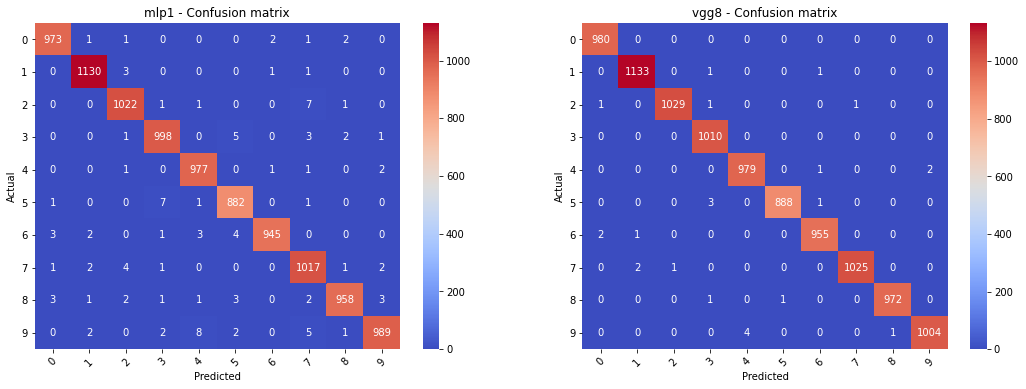

2021-08-10 15:26:20,397: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8


----------------------------------------sample analysis----------------------------------------


2021-08-10 15:26:22,238: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 15:26:22,239: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/custom1
2021-08-10 15:26:23,228: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 15:26:23,230: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20
2021-08-10 15:26:28,261: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 15:26:28,263: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/

2021-08-10 15:26:30,576: WARNING: 5 out of the last 631 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f3cfc08b510> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


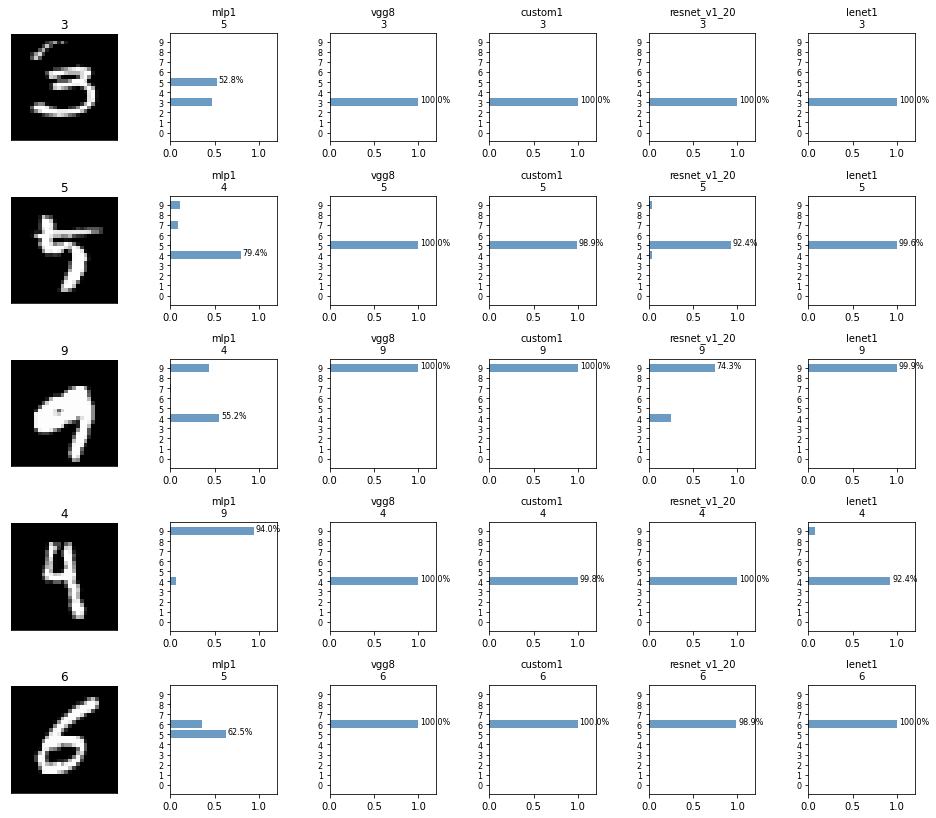

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,vgg8,1442378,2550.9,2021-08-10 12:47,0.0011,0.0126,0.9996,0.9975,1.0,1.0000
2,custom1,73162,2225.0,2021-08-10 12:03,0.0048,0.0115,0.9987,0.9970,1.0,1.0000
3,resnet_v1_20,272778,4343.1,2021-08-10 14:00,0.0204,0.0270,0.9991,0.9968,1.0,1.0000
4,lenet1,61750,2963.8,2021-08-10 11:25,0.0088,0.0148,0.9971,0.9956,1.0,1.0000
5,mlp1,101770,2681.3,2021-08-10 15:26,0.0183,0.0364,0.9945,0.9891,1.0,0.9999


In [17]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

2021-08-10 15:26:35,131: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/mlp1
----------------------------------------evaluate----------------------------------------


2021-08-10 15:26:41,055: INFO: test loss:0.0364
2021-08-10 15:26:41,056: INFO: test accuracy:0.9891
2021-08-10 15:26:41,057: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/results.json
2021-08-10 15:26:41,059: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/results.json
2021-08-10 15:26:41,060: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 15:26:41,061: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 15:26:41,062: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 15:26:42,806: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator


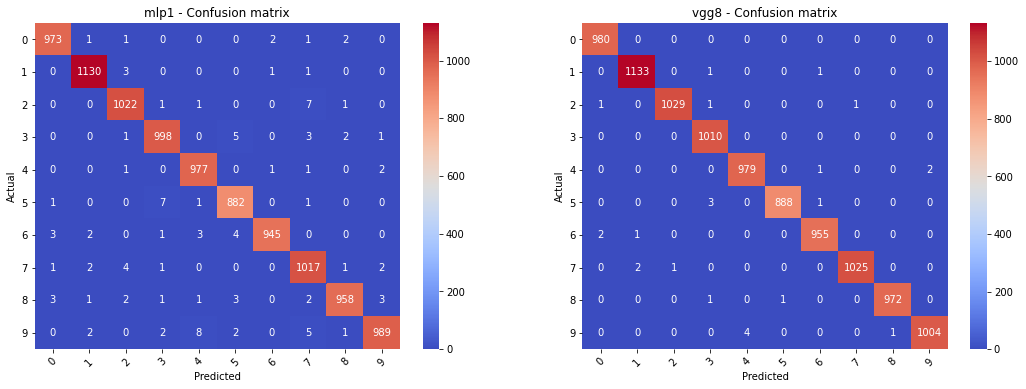

2021-08-10 15:26:46,787: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8


----------------------------------------sample analysis----------------------------------------


2021-08-10 15:26:48,401: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 15:26:48,403: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/custom1
2021-08-10 15:26:49,367: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 15:26:49,370: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20
2021-08-10 15:26:54,461: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 15:26:54,464: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/

2021-08-10 15:26:56,652: WARNING: 5 out of the last 631 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f3d2b1052f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


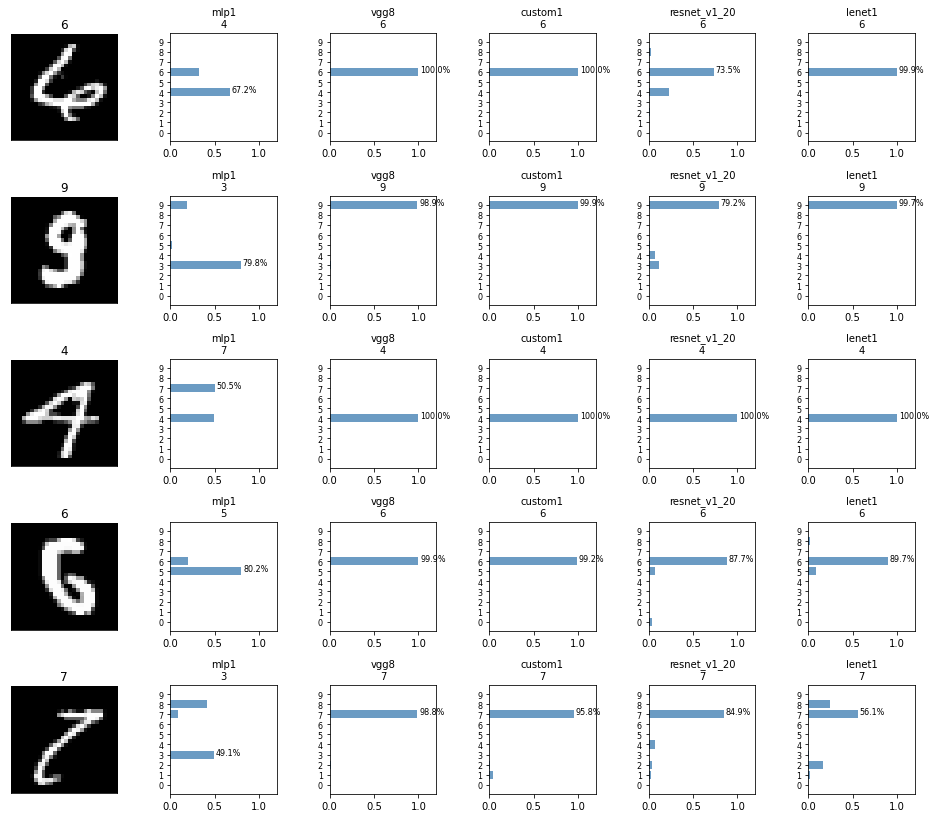

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,vgg8,1442378,2550.9,2021-08-10 12:47,0.0011,0.0126,0.9996,0.9975,1.0,1.0000
2,custom1,73162,2225.0,2021-08-10 12:03,0.0048,0.0115,0.9987,0.9970,1.0,1.0000
3,resnet_v1_20,272778,4343.1,2021-08-10 14:00,0.0204,0.0270,0.9991,0.9968,1.0,1.0000
4,lenet1,61750,2963.8,2021-08-10 11:25,0.0088,0.0148,0.9971,0.9956,1.0,1.0000
5,mlp1,101770,2681.3,2021-08-10 15:26,0.0183,0.0364,0.9945,0.9891,1.0,0.9999


In [18]:
helper.model_summary(model, history, show_sample_analysis=True) 




从上面的错误来看，模型对一些细节的判断不是很准。下面来尝试一下LeNet。

### LeNet

![image-20201019113632136](images/image-20201019113632136.png)

LeNet诞生于1994年，是Yann LeCun等人提出的，是最早的卷积神经网络之一。在LeNet中，输入层是32×32的图片，而MNIST是28×28的图片，为了保持模型的结构不变，在第一个Conv2D设置参数padding=’same’。首先创建模型，并训练。

2021-08-10 15:27:01,597: INFO: model_params.lenet1.dropout=0.2
2021-08-10 15:27:01,705: INFO: learning_rate=0.001
2021-08-10 15:27:01,706: INFO: model_params.lenet1.clip_value=None
2021-08-10 15:27:01,713: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1


Model: "lenet1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 6)         24        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 16)        64   

2021-08-10 15:27:01,720: INFO: model_params.lenet1.epochs=120
2021-08-10 15:27:01,720: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1, monitor=val_accuracy)
2021-08-10 15:27:01,721: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 15:27:01,721: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 15:27:01,722: INFO: use LearningRateScheduler()
2021-08-10 15:27:01,723: INFO: steps_per_epoch=1875
2021-08-10 15:27:01,723: INFO: start training
2021-08-10 15:27:01,724: INFO: use_class_weight=False



_________________________________________________________________
dropout_4 (Dropout)          (None, 84)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                850       
Total params: 61,794
Trainable params: 61,750
Non-trainable params: 44
_________________________________________________________________
Epoch 1/120
1875/1875 [==============================] - 24s 12ms/step - loss: 0.3769 - accuracy: 0.8808 - val_loss: 0.0514 - val_accuracy: 0.9828
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1/assets


2021-08-10 15:27:27,442: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1/assets


Epoch 2/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.1640 - accuracy: 0.9508 - val_loss: 0.0433 - val_accuracy: 0.9870
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1/assets


2021-08-10 15:27:52,326: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1/assets


Epoch 3/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.1341 - accuracy: 0.9600 - val_loss: 0.0419 - val_accuracy: 0.9866
Epoch 4/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.1167 - accuracy: 0.9652 - val_loss: 0.0405 - val_accuracy: 0.9863
Epoch 5/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.1092 - accuracy: 0.9669 - val_loss: 0.0383 - val_accuracy: 0.9874
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1/assets


2021-08-10 15:29:02,878: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1/assets


Epoch 6/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.1017 - accuracy: 0.9705 - val_loss: 0.0449 - val_accuracy: 0.9861
Epoch 7/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0963 - accuracy: 0.9717 - val_loss: 0.0248 - val_accuracy: 0.9920
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1/assets


2021-08-10 15:29:50,870: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1/assets


Epoch 8/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0920 - accuracy: 0.9729 - val_loss: 0.0239 - val_accuracy: 0.9921
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1/assets


2021-08-10 15:30:16,039: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1/assets


Epoch 9/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0866 - accuracy: 0.9748 - val_loss: 0.0265 - val_accuracy: 0.9907
Epoch 10/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0831 - accuracy: 0.9758 - val_loss: 0.0239 - val_accuracy: 0.9921
Epoch 11/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0817 - accuracy: 0.9761 - val_loss: 0.0244 - val_accuracy: 0.9916
Epoch 12/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0780 - accuracy: 0.9768 - val_loss: 0.0224 - val_accuracy: 0.9931
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1/assets


2021-08-10 15:31:49,575: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1/assets


Epoch 13/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0739 - accuracy: 0.9779 - val_loss: 0.0256 - val_accuracy: 0.9921
Epoch 14/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0754 - accuracy: 0.9778 - val_loss: 0.0209 - val_accuracy: 0.9933
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1/assets


2021-08-10 15:32:37,358: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1/assets


Epoch 15/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0722 - accuracy: 0.9784 - val_loss: 0.0219 - val_accuracy: 0.9926
Epoch 16/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0717 - accuracy: 0.9789 - val_loss: 0.0196 - val_accuracy: 0.9937
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1/assets


2021-08-10 15:33:25,407: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1/assets


Epoch 17/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0728 - accuracy: 0.9792 - val_loss: 0.0229 - val_accuracy: 0.9909
Epoch 18/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0689 - accuracy: 0.9794 - val_loss: 0.0200 - val_accuracy: 0.9933
Epoch 19/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0665 - accuracy: 0.9795 - val_loss: 0.0205 - val_accuracy: 0.9929
Epoch 20/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0646 - accuracy: 0.9808 - val_loss: 0.0204 - val_accuracy: 0.9935
Epoch 21/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0657 - accuracy: 0.9803 - val_loss: 0.0191 - val_accuracy: 0.9933
Epoch 22/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0640 - accuracy: 0.9803 - val_loss: 0.0236 - val_accuracy: 0.9922
Epoch 23/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0656 - accuracy: 0.9803 - val_

2021-08-10 15:36:07,354: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1/assets


Epoch 24/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0635 - accuracy: 0.9811 - val_loss: 0.0174 - val_accuracy: 0.9947
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1/assets


2021-08-10 15:36:32,230: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1/assets


Epoch 25/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0628 - accuracy: 0.9813 - val_loss: 0.0191 - val_accuracy: 0.9934
Epoch 26/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0596 - accuracy: 0.9821 - val_loss: 0.0213 - val_accuracy: 0.9926
Epoch 27/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0611 - accuracy: 0.9819 - val_loss: 0.0191 - val_accuracy: 0.9946
Epoch 28/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0594 - accuracy: 0.9820 - val_loss: 0.0218 - val_accuracy: 0.9930
Epoch 29/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0603 - accuracy: 0.9822 - val_loss: 0.0206 - val_accuracy: 0.9932
Epoch 30/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0588 - accuracy: 0.9827 - val_loss: 0.0211 - val_accuracy: 0.9927
Epoch 31/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0579 - accuracy: 0.9828 - val_

2021-08-10 15:45:32,722: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1/assets


Epoch 47/120
Epoch 00047: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0435 - accuracy: 0.9864 - val_loss: 0.0151 - val_accuracy: 0.9948
Epoch 48/120
Epoch 00048: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0426 - accuracy: 0.9865 - val_loss: 0.0150 - val_accuracy: 0.9951
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1/assets


2021-08-10 15:46:20,587: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1/assets


Epoch 49/120
Epoch 00049: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0418 - accuracy: 0.9876 - val_loss: 0.0155 - val_accuracy: 0.9949
Epoch 50/120
Epoch 00050: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0429 - accuracy: 0.9869 - val_loss: 0.0162 - val_accuracy: 0.9944
Epoch 51/120
Epoch 00051: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0432 - accuracy: 0.9871 - val_loss: 0.0161 - val_accuracy: 0.9943
Epoch 52/120
Epoch 00052: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0418 - accuracy: 0.9873 - val_loss: 0.0166 - val_accuracy: 0.9941
Epoch 53/120
Epoch 00053: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0

2021-08-10 16:01:26,980: INFO: finish training [elapsed time: 2065.26 seconds]


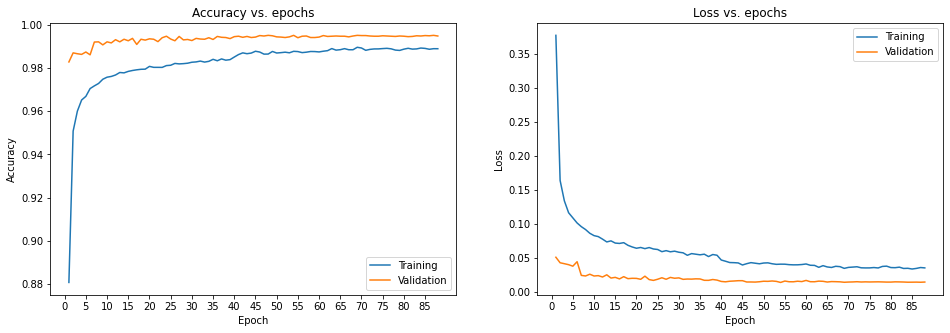

2021-08-10 16:01:27,523: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1
----------------------------------------evaluate----------------------------------------


2021-08-10 16:01:37,348: INFO: test loss:0.0150
2021-08-10 16:01:37,349: INFO: test accuracy:0.9951
2021-08-10 16:01:37,352: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/results.json
2021-08-10 16:01:37,354: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/results.json
2021-08-10 16:01:37,355: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 16:01:37,356: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 16:01:37,357: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 16:01:38,995: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator


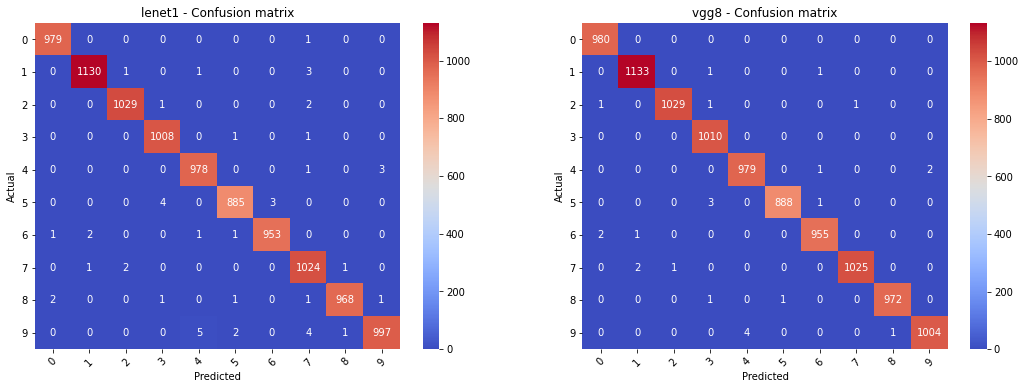

2021-08-10 16:01:42,759: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8


----------------------------------------sample analysis----------------------------------------


2021-08-10 16:01:44,785: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 16:01:44,786: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/custom1
2021-08-10 16:01:45,805: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 16:01:45,808: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20
2021-08-10 16:01:50,713: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 16:01:50,715: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/

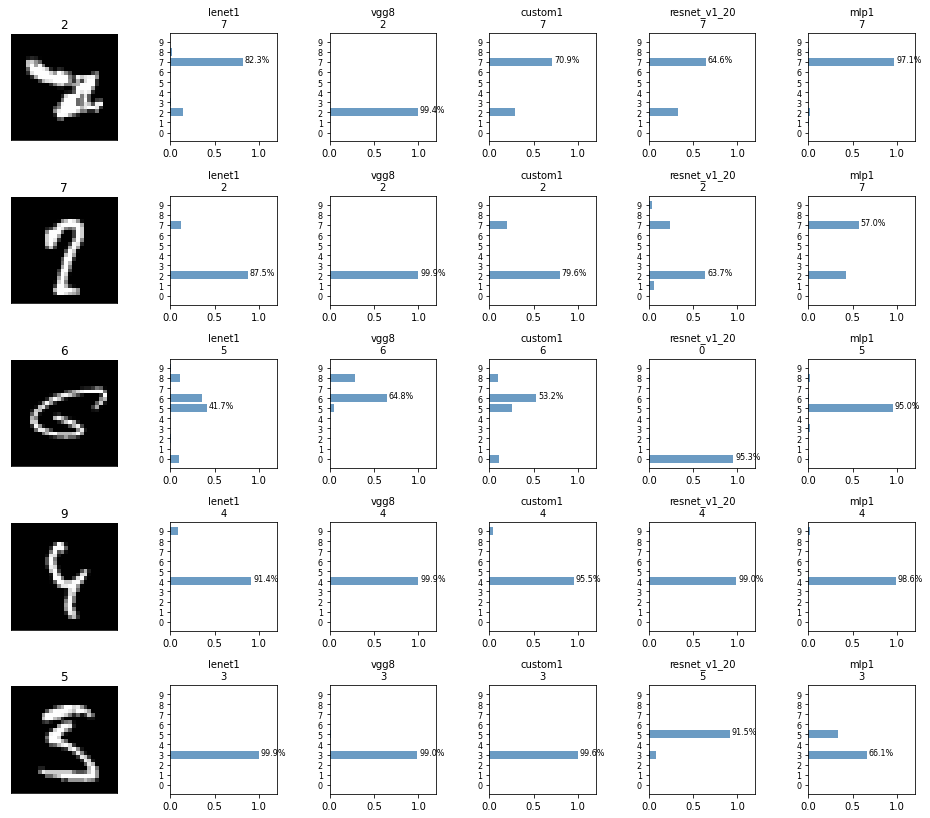

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,vgg8,1442378,2550.9,2021-08-10 12:47,0.0011,0.0126,0.9996,0.9975,1.0,1.0000
2,custom1,73162,2225.0,2021-08-10 12:03,0.0048,0.0115,0.9987,0.9970,1.0,1.0000
3,resnet_v1_20,272778,4343.1,2021-08-10 14:00,0.0204,0.0270,0.9991,0.9968,1.0,1.0000
4,lenet1,61750,2064.8,2021-08-10 16:01,0.0110,0.0150,0.9963,0.9951,1.0,1.0000
5,mlp1,101770,2681.3,2021-08-10 15:26,0.0183,0.0364,0.9945,0.9891,1.0,0.9999


In [19]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

从上面的图中，可以看到，Lenet的参数只有mlp的60%，但其的准确率比mlp提升了差不多1%。上面最后一张图中，有三列，第一列是数字图片，它们是mlp中分错的数字，第二列是mlp中的分类，第三列是lenet中的分类，可以看到lenet的确学到了一些mlp中没有的模式。下面再来看看哪些数字在lenet也分错了。

### Custom 1

下面自己定义一个模型，这个模型和lenet的主要区别是，增加了卷积的深度

2021-08-10 16:01:56,874: INFO: model_params.custom1.dropout=0.2
2021-08-10 16:01:56,985: INFO: learning_rate=0.001
2021-08-10 16:01:56,986: INFO: model_params.custom1.clip_value=None
2021-08-10 16:01:56,992: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/custom1
2021-08-10 16:01:56,999: INFO: model_params.custom1.epochs=120
2021-08-10 16:01:57,000: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/custom1, monitor=val_accuracy)
2021-08-10 16:01:57,000: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 16:01:57,001: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 16:01:57,002: INFO: use LearningRateScheduler()
2021-08-10 16:01:57,003: INFO: steps_per_epoch=1875
2021-08-10 16:01:57,004: INFO: start training
2021-08-10 16:01:57,004: INFO

Model: "custom1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 12, 12, 64)        256 

2021-08-10 16:02:23,558: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/custom1/assets


Epoch 2/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.1105 - accuracy: 0.9659 - val_loss: 0.0396 - val_accuracy: 0.9874
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/custom1/assets


2021-08-10 16:02:48,609: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/custom1/assets


Epoch 3/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0881 - accuracy: 0.9735 - val_loss: 0.0429 - val_accuracy: 0.9860
Epoch 4/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0782 - accuracy: 0.9771 - val_loss: 0.0254 - val_accuracy: 0.9912
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/custom1/assets


2021-08-10 16:03:36,091: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/custom1/assets


Epoch 5/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0709 - accuracy: 0.9785 - val_loss: 0.0250 - val_accuracy: 0.9915
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/custom1/assets


2021-08-10 16:04:01,302: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/custom1/assets


Epoch 6/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0641 - accuracy: 0.9806 - val_loss: 0.0309 - val_accuracy: 0.9910
Epoch 7/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0614 - accuracy: 0.9818 - val_loss: 0.0244 - val_accuracy: 0.9926
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/custom1/assets


2021-08-10 16:05:07,625: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/custom1/assets


Epoch 8/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0584 - accuracy: 0.9822 - val_loss: 0.0176 - val_accuracy: 0.9950
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/custom1/assets


2021-08-10 16:05:32,828: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/custom1/assets


Epoch 9/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0565 - accuracy: 0.9834 - val_loss: 0.0309 - val_accuracy: 0.9901
Epoch 10/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0537 - accuracy: 0.9839 - val_loss: 0.0167 - val_accuracy: 0.9952
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/custom1/assets


2021-08-10 16:06:20,654: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/custom1/assets


Epoch 11/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0519 - accuracy: 0.9850 - val_loss: 0.0189 - val_accuracy: 0.9939
Epoch 12/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0517 - accuracy: 0.9847 - val_loss: 0.0179 - val_accuracy: 0.9941
Epoch 13/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0498 - accuracy: 0.9850 - val_loss: 0.0182 - val_accuracy: 0.9940
Epoch 14/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0465 - accuracy: 0.9862 - val_loss: 0.0165 - val_accuracy: 0.9942
Epoch 15/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0460 - accuracy: 0.9862 - val_loss: 0.0183 - val_accuracy: 0.9942
Epoch 16/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0439 - accuracy: 0.9868 - val_loss: 0.0167 - val_accuracy: 0.9946
Epoch 17/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0452 - accuracy: 0.9862 - val_

2021-08-10 16:10:06,305: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/custom1/assets


Epoch 20/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0404 - accuracy: 0.9879 - val_loss: 0.0190 - val_accuracy: 0.9935
Epoch 21/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0421 - accuracy: 0.9876 - val_loss: 0.0196 - val_accuracy: 0.9950
Epoch 22/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0409 - accuracy: 0.9875 - val_loss: 0.0177 - val_accuracy: 0.9943
Epoch 23/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0396 - accuracy: 0.9886 - val_loss: 0.0153 - val_accuracy: 0.9956
Epoch 24/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0376 - accuracy: 0.9884 - val_loss: 0.0176 - val_accuracy: 0.9945
Epoch 25/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0377 - accuracy: 0.9887 - val_loss: 0.0172 - val_accuracy: 0.9947
Epoch 26/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0381 - accuracy: 0.9889 - val_

2021-08-10 16:16:36,271: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/custom1/assets


Epoch 37/120
Epoch 00037: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0267 - accuracy: 0.9918 - val_loss: 0.0154 - val_accuracy: 0.9952
Epoch 38/120
Epoch 00038: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0269 - accuracy: 0.9916 - val_loss: 0.0142 - val_accuracy: 0.9960
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/custom1/assets


2021-08-10 16:17:23,865: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/custom1/assets


Epoch 39/120
Epoch 00039: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0247 - accuracy: 0.9925 - val_loss: 0.0129 - val_accuracy: 0.9959
Epoch 40/120
Epoch 00040: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0255 - accuracy: 0.9921 - val_loss: 0.0156 - val_accuracy: 0.9959
Epoch 41/120
Epoch 00041: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0254 - accuracy: 0.9920 - val_loss: 0.0138 - val_accuracy: 0.9959
Epoch 42/120
Epoch 00042: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0273 - accuracy: 0.9917 - val_loss: 0.0142 - val_accuracy: 0.9956
Epoch 43/120
Epoch 00043: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0

2021-08-10 16:23:30,745: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/custom1/assets


Epoch 55/120
Epoch 00055: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0227 - accuracy: 0.9931 - val_loss: 0.0124 - val_accuracy: 0.9961
Epoch 56/120
Epoch 00056: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0225 - accuracy: 0.9930 - val_loss: 0.0139 - val_accuracy: 0.9955
Epoch 57/120
Epoch 00057: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0237 - accuracy: 0.9930 - val_loss: 0.0139 - val_accuracy: 0.9955
Epoch 58/120
Epoch 00058: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0216 - accuracy: 0.9931 - val_loss: 0.0136 - val_accuracy: 0.9956
Epoch 59/120
Epoch 00059: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0

1875/1875 [==============================] - 23s 12ms/step - loss: 0.0187 - accuracy: 0.9942 - val_loss: 0.0130 - val_accuracy: 0.9958
Epoch 94/120
Epoch 00094: Still keep learning rate 3.2e-06 instead of 1e-05
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0196 - accuracy: 0.9939 - val_loss: 0.0129 - val_accuracy: 0.9958
Epoch 00094: early stopping


2021-08-10 16:38:59,774: INFO: finish training [elapsed time: 2222.77 seconds]


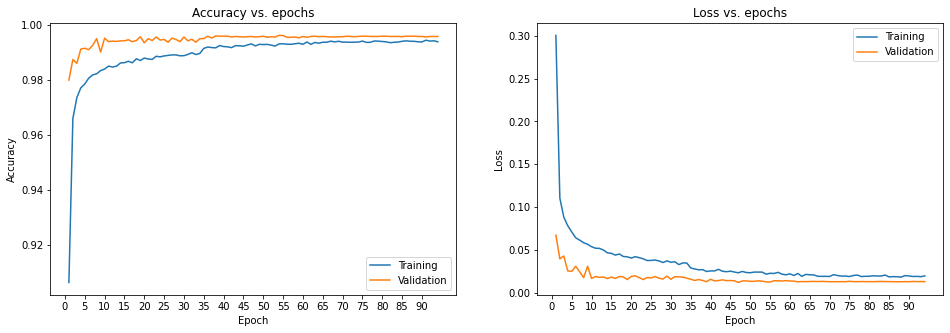

2021-08-10 16:39:00,277: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/custom1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/custom1
----------------------------------------evaluate----------------------------------------


2021-08-10 16:39:11,188: INFO: test loss:0.0126
2021-08-10 16:39:11,189: INFO: test accuracy:0.9962
2021-08-10 16:39:11,191: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/results.json
2021-08-10 16:39:11,193: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/results.json
2021-08-10 16:39:11,193: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 16:39:11,194: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 16:39:11,195: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 16:39:12,792: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator


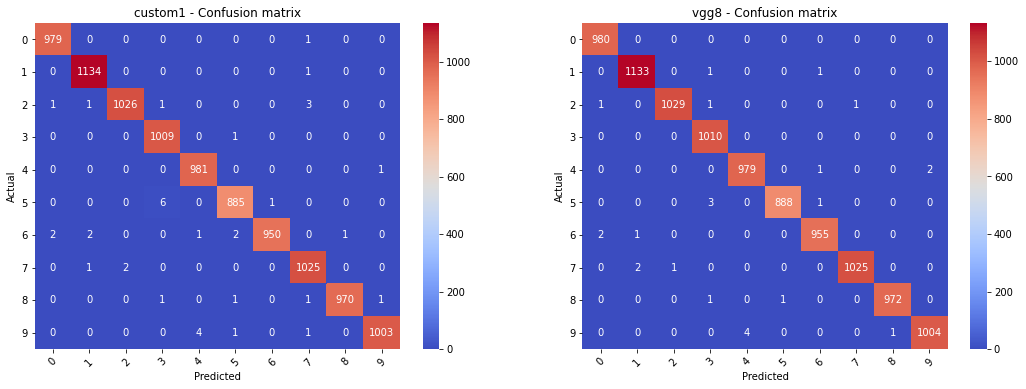

2021-08-10 16:39:16,530: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8


----------------------------------------sample analysis----------------------------------------


2021-08-10 16:39:18,502: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 16:39:18,505: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20
2021-08-10 16:39:23,071: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 16:39:23,074: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1
2021-08-10 16:39:23,881: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 16:39:23,884: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/5

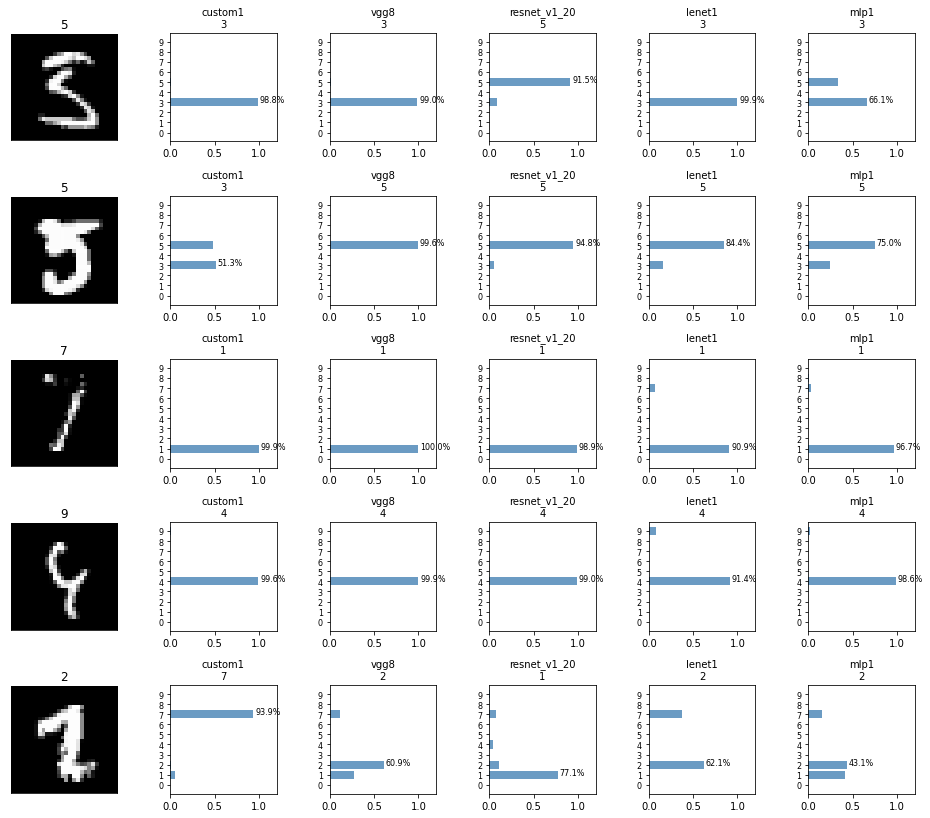

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,vgg8,1442378,2550.9,2021-08-10 12:47,0.0011,0.0126,0.9996,0.9975,1.0,1.0000
2,resnet_v1_20,272778,4343.1,2021-08-10 14:00,0.0204,0.0270,0.9991,0.9968,1.0,1.0000
3,custom1,73162,2222.3,2021-08-10 16:39,0.0046,0.0126,0.9987,0.9962,1.0,1.0000
4,lenet1,61750,2064.8,2021-08-10 16:01,0.0110,0.0150,0.9963,0.9951,1.0,1.0000
5,mlp1,101770,2681.3,2021-08-10 15:26,0.0183,0.0364,0.9945,0.9891,1.0,0.9999


In [20]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### VGG

2021-08-10 16:39:30,413: INFO: model_params.vgg8.dropout=0.3
2021-08-10 16:39:30,611: INFO: learning_rate=0.001
2021-08-10 16:39:30,611: INFO: model_params.vgg8.clip_value=None
2021-08-10 16:39:30,618: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8
2021-08-10 16:39:30,627: INFO: model_params.vgg8.epochs=120
2021-08-10 16:39:30,628: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8, monitor=val_accuracy)
2021-08-10 16:39:30,629: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 16:39:30,629: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 16:39:30,630: INFO: use LearningRateScheduler()
2021-08-10 16:39:30,631: INFO: steps_per_epoch=1875
2021-08-10 16:39:30,631: INFO: start training
2021-08-10 16:39:30,632: INFO: use_class_wei

Model: "vgg8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_con1 (Conv2D)         (None, 28, 28, 64)        640       
_________________________________________________________________
block1_bn1 (BatchNormalizati (None, 28, 28, 64)        256       
_________________________________________________________________
block1_relu1 (ReLU)          (None, 28, 28, 64)        0         
_________________________________________________________________
block1_con2 (Conv2D)         (None, 28, 28, 64)        36928     
_________________________________________________________________
block1_bn2 (BatchNormalizati (None, 28, 28, 64)        256       
_________________________________________________________________
block1_relu2 (ReLU)          (None, 28, 28, 64)        0      

2021-08-10 16:39:59,633: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8/assets


Epoch 2/120
1875/1875 [==============================] - 24s 13ms/step - loss: 0.1083 - accuracy: 0.9691 - val_loss: 0.0955 - val_accuracy: 0.9756
Epoch 3/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0824 - accuracy: 0.9775 - val_loss: 0.0332 - val_accuracy: 0.9892
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8/assets


2021-08-10 16:40:50,589: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8/assets


Epoch 4/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0660 - accuracy: 0.9819 - val_loss: 0.0177 - val_accuracy: 0.9944
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8/assets


2021-08-10 16:41:18,058: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8/assets


Epoch 5/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0596 - accuracy: 0.9833 - val_loss: 0.0411 - val_accuracy: 0.9890
Epoch 6/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0522 - accuracy: 0.9858 - val_loss: 0.0210 - val_accuracy: 0.9933
Epoch 7/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0440 - accuracy: 0.9876 - val_loss: 0.0187 - val_accuracy: 0.9943
Epoch 8/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0388 - accuracy: 0.9896 - val_loss: 0.0244 - val_accuracy: 0.9933
Epoch 9/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0378 - accuracy: 0.9896 - val_loss: 0.0230 - val_accuracy: 0.9932
Epoch 10/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0343 - accuracy: 0.9904 - val_loss: 0.0182 - val_accuracy: 0.9951
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/ou

2021-08-10 16:43:41,945: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8/assets


Epoch 11/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0306 - accuracy: 0.9908 - val_loss: 0.0185 - val_accuracy: 0.9947
Epoch 12/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0307 - accuracy: 0.9912 - val_loss: 0.0208 - val_accuracy: 0.9944
Epoch 13/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0290 - accuracy: 0.9920 - val_loss: 0.0141 - val_accuracy: 0.9953
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8/assets


2021-08-10 16:44:55,982: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8/assets


Epoch 14/120
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0280 - accuracy: 0.9921 - val_loss: 0.0290 - val_accuracy: 0.9914
Epoch 15/120
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0260 - accuracy: 0.9923 - val_loss: 0.0174 - val_accuracy: 0.9942
Epoch 16/120
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0248 - accuracy: 0.9927 - val_loss: 0.0143 - val_accuracy: 0.9954
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8/assets


2021-08-10 16:46:26,020: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8/assets


Epoch 17/120
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0245 - accuracy: 0.9930 - val_loss: 0.0148 - val_accuracy: 0.9960
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8/assets


2021-08-10 16:46:58,875: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8/assets


Epoch 18/120
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0242 - accuracy: 0.9933 - val_loss: 0.0149 - val_accuracy: 0.9962
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8/assets


2021-08-10 16:47:31,908: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8/assets


Epoch 19/120
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0234 - accuracy: 0.9936 - val_loss: 0.0123 - val_accuracy: 0.9960
Epoch 20/120
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0241 - accuracy: 0.9932 - val_loss: 0.0120 - val_accuracy: 0.9965
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8/assets


2021-08-10 16:48:34,754: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8/assets


Epoch 21/120
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0214 - accuracy: 0.9940 - val_loss: 0.0130 - val_accuracy: 0.9953
Epoch 22/120
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0220 - accuracy: 0.9936 - val_loss: 0.0102 - val_accuracy: 0.9972
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8/assets


2021-08-10 16:49:36,726: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8/assets


Epoch 23/120
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0219 - accuracy: 0.9939 - val_loss: 0.0135 - val_accuracy: 0.9968
Epoch 24/120
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0214 - accuracy: 0.9937 - val_loss: 0.0151 - val_accuracy: 0.9951
Epoch 25/120
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0195 - accuracy: 0.9946 - val_loss: 0.0135 - val_accuracy: 0.9962
Epoch 26/120
1875/1875 [==============================] - 29s 16ms/step - loss: 0.0185 - accuracy: 0.9946 - val_loss: 0.0196 - val_accuracy: 0.9954
Epoch 27/120
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0183 - accuracy: 0.9947 - val_loss: 0.0117 - val_accuracy: 0.9967
Epoch 28/120
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0181 - accuracy: 0.9947 - val_loss: 0.0147 - val_accuracy: 0.9957
Epoch 29/120
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0172 - accuracy: 0.9952 - val_

2021-08-10 17:02:07,300: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8/assets


Epoch 48/120
Epoch 00048: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0080 - accuracy: 0.9976 - val_loss: 0.0110 - val_accuracy: 0.9967
Epoch 49/120
Epoch 00049: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0076 - accuracy: 0.9976 - val_loss: 0.0121 - val_accuracy: 0.9967
Epoch 50/120
Epoch 00050: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0077 - accuracy: 0.9978 - val_loss: 0.0106 - val_accuracy: 0.9968
Epoch 51/120
Epoch 00051: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0068 - accuracy: 0.9978 - val_loss: 0.0123 - val_accuracy: 0.9966
Epoch 52/120
Epoch 00052: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0

1875/1875 [==============================] - 30s 16ms/step - loss: 0.0046 - accuracy: 0.9987 - val_loss: 0.0134 - val_accuracy: 0.9965
Epoch 86/120
Epoch 00086: Still keep learning rate 1e-05 instead of 0.0001
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.0133 - val_accuracy: 0.9965
Epoch 87/120
Epoch 00087: Still keep learning rate 1e-05 instead of 0.0001
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0037 - accuracy: 0.9988 - val_loss: 0.0135 - val_accuracy: 0.9965
Epoch 00087: early stopping


2021-08-10 17:22:09,135: INFO: finish training [elapsed time: 2558.50 seconds]


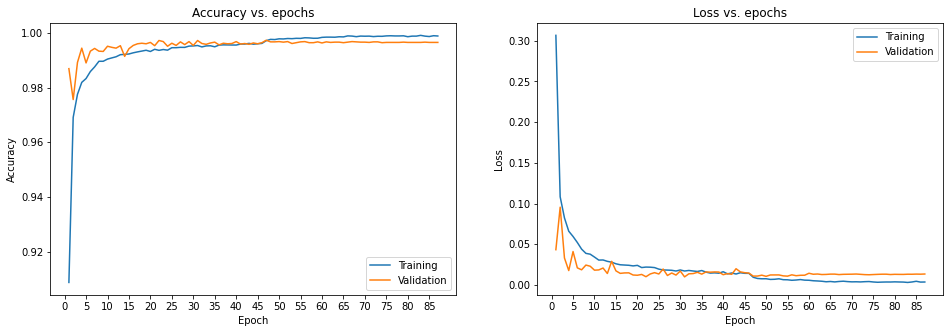

2021-08-10 17:22:09,622: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8
----------------------------------------evaluate----------------------------------------


2021-08-10 17:22:26,980: INFO: test loss:0.0109
2021-08-10 17:22:26,981: INFO: test accuracy:0.9973
2021-08-10 17:22:26,983: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/results.json
2021-08-10 17:22:26,984: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/results.json
2021-08-10 17:22:26,985: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 17:22:26,986: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 17:22:26,987: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 17:22:32,163: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator


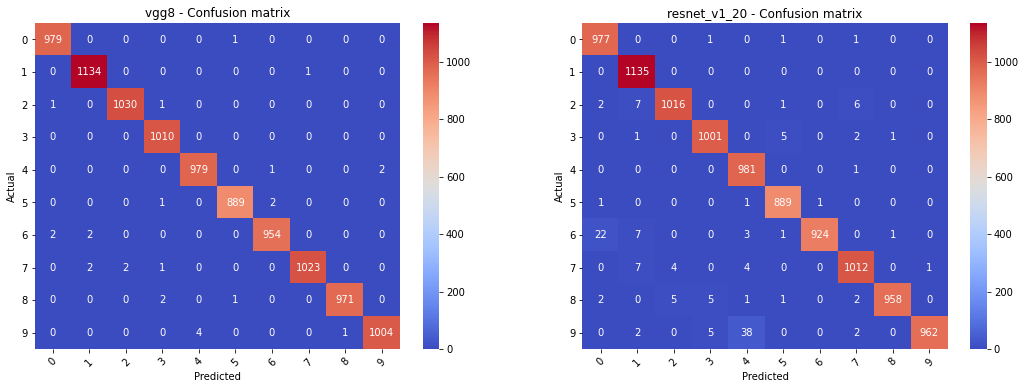

2021-08-10 17:22:37,722: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20


----------------------------------------sample analysis----------------------------------------


2021-08-10 17:22:42,890: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 17:22:42,891: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/custom1
2021-08-10 17:22:43,837: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 17:22:43,839: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1
2021-08-10 17:22:44,977: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 17:22:44,979: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-ten

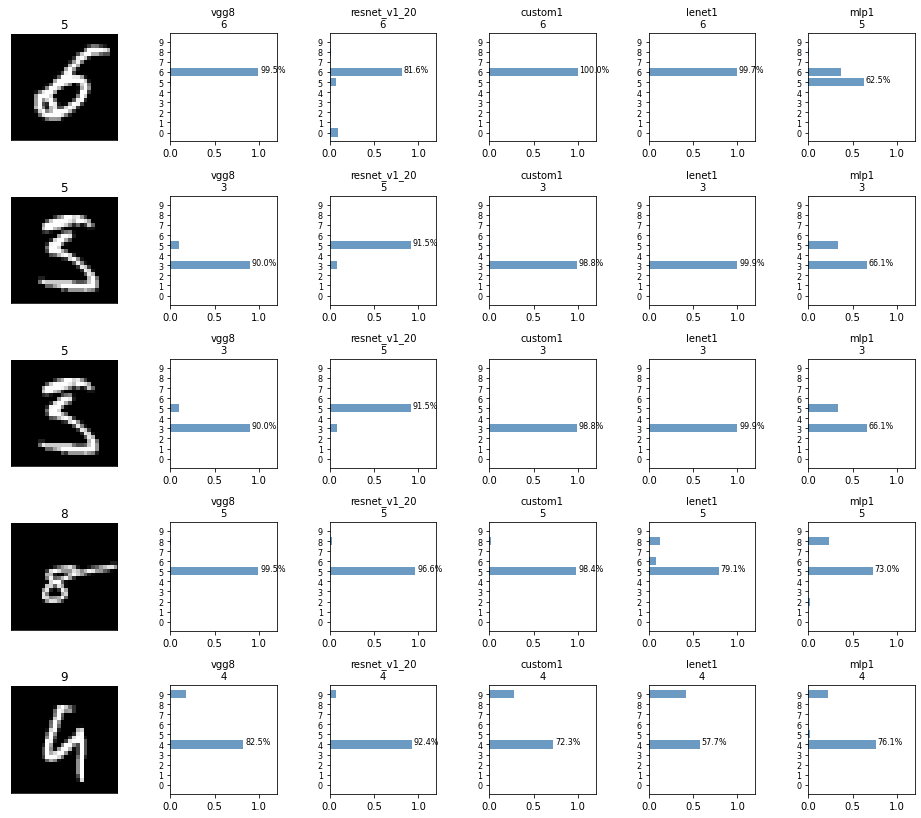

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,vgg8,1442378,2558.0,2021-08-10 17:22,0.0018,0.0109,0.9994,0.9973,1.0,1.0000
2,resnet_v1_20,272778,4343.1,2021-08-10 14:00,0.0204,0.0270,0.9991,0.9968,1.0,1.0000
3,custom1,73162,2222.3,2021-08-10 16:39,0.0046,0.0126,0.9987,0.9962,1.0,1.0000
4,lenet1,61750,2064.8,2021-08-10 16:01,0.0110,0.0150,0.9963,0.9951,1.0,1.0000
5,mlp1,101770,2681.3,2021-08-10 15:26,0.0183,0.0364,0.9945,0.9891,1.0,0.9999


In [21]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3,)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### Resnet

参考https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

2021-08-10 17:22:51,784: INFO: learning_rate=0.001
2021-08-10 17:22:51,785: INFO: model_params.resnet_v1_20.clip_value=None
2021-08-10 17:22:51,792: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20
2021-08-10 17:22:51,811: INFO: model_params.resnet_v1_20.epochs=120
2021-08-10 17:22:51,812: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20, monitor=val_accuracy)
2021-08-10 17:22:51,812: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 17:22:51,813: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 17:22:51,814: INFO: use LearningRateScheduler()
2021-08-10 17:22:51,815: INFO: steps_per_epoch=1875
2021-08-10 17:22:51,815: INFO: start training
2021-08-10 17:22:51,816: INFO: use_class_weight=False


Model: "resnet_v1_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 16)   160         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 28, 28, 16)   64          conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 28, 28, 16)   0           batch_normalization_5[0][0]      
_______________________________________________________________________________________

1875/1875 [==============================] - 49s 25ms/step - loss: 0.3160 - accuracy: 0.9507 - val_loss: 0.5213 - val_accuracy: 0.8627


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 17:23:52,544: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 2/120
1875/1875 [==============================] - 46s 24ms/step - loss: 0.1835 - accuracy: 0.9800 - val_loss: 0.1849 - val_accuracy: 0.9760


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 17:24:49,840: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 3/120
1875/1875 [==============================] - 46s 25ms/step - loss: 0.1525 - accuracy: 0.9829 - val_loss: 0.1236 - val_accuracy: 0.9889


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 17:25:47,666: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 4/120
1875/1875 [==============================] - 46s 24ms/step - loss: 0.1341 - accuracy: 0.9837 - val_loss: 0.1125 - val_accuracy: 0.9893


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 17:26:45,417: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 5/120
1875/1875 [==============================] - 46s 24ms/step - loss: 0.1185 - accuracy: 0.9851 - val_loss: 0.1138 - val_accuracy: 0.9856
Epoch 6/120
1875/1875 [==============================] - 46s 24ms/step - loss: 0.1097 - accuracy: 0.9857 - val_loss: 0.1171 - val_accuracy: 0.9817
Epoch 7/120
1875/1875 [==============================] - 46s 24ms/step - loss: 0.1032 - accuracy: 0.9865 - val_loss: 0.0920 - val_accuracy: 0.9895


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 17:29:14,454: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 8/120
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0966 - accuracy: 0.9873 - val_loss: 0.2463 - val_accuracy: 0.9422
Epoch 9/120
1875/1875 [==============================] - 46s 25ms/step - loss: 0.0918 - accuracy: 0.9879 - val_loss: 0.0828 - val_accuracy: 0.9896


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 17:30:58,235: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 10/120
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0892 - accuracy: 0.9880 - val_loss: 0.1334 - val_accuracy: 0.9735
Epoch 11/120
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0838 - accuracy: 0.9887 - val_loss: 0.1071 - val_accuracy: 0.9809
Epoch 12/120
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0798 - accuracy: 0.9891 - val_loss: 0.0707 - val_accuracy: 0.9907


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 17:33:27,168: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 13/120
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0801 - accuracy: 0.9888 - val_loss: 0.0710 - val_accuracy: 0.9908


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 17:34:24,788: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 14/120
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0774 - accuracy: 0.9889 - val_loss: 0.0618 - val_accuracy: 0.9923


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 17:35:22,470: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 15/120
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0736 - accuracy: 0.9896 - val_loss: 0.0609 - val_accuracy: 0.9922
Epoch 16/120
1875/1875 [==============================] - 45s 24ms/step - loss: 0.0712 - accuracy: 0.9898 - val_loss: 0.0855 - val_accuracy: 0.9846
Epoch 17/120
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0701 - accuracy: 0.9901 - val_loss: 0.0601 - val_accuracy: 0.9920
Epoch 18/120
1875/1875 [==============================] - 44s 24ms/step - loss: 0.0703 - accuracy: 0.9894 - val_loss: 0.0765 - val_accuracy: 0.9885
Epoch 19/120
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0673 - accuracy: 0.9905 - val_loss: 0.0747 - val_accuracy: 0.9866
Epoch 20/120
1875/1875 [==============================] - 44s 23ms/step - loss: 0.0660 - accuracy: 0.9903 - val_loss: 0.0551 - val_accuracy: 0.9931


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 17:40:05,245: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 21/120
1875/1875 [==============================] - 44s 24ms/step - loss: 0.0641 - accuracy: 0.9904 - val_loss: 0.0557 - val_accuracy: 0.9923
Epoch 22/120
1875/1875 [==============================] - 44s 23ms/step - loss: 0.0642 - accuracy: 0.9903 - val_loss: 0.0542 - val_accuracy: 0.9934


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 17:41:45,312: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 23/120
1875/1875 [==============================] - 44s 24ms/step - loss: 0.0637 - accuracy: 0.9910 - val_loss: 0.0833 - val_accuracy: 0.9850
Epoch 24/120
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0617 - accuracy: 0.9908 - val_loss: 0.0741 - val_accuracy: 0.9879
Epoch 25/120
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0628 - accuracy: 0.9903 - val_loss: 0.0508 - val_accuracy: 0.9930
Epoch 26/120
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0602 - accuracy: 0.9910 - val_loss: 0.0463 - val_accuracy: 0.9949


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 17:44:58,176: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 27/120
1875/1875 [==============================] - 44s 24ms/step - loss: 0.0586 - accuracy: 0.9918 - val_loss: 0.0899 - val_accuracy: 0.9810
Epoch 28/120
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0596 - accuracy: 0.9907 - val_loss: 0.0605 - val_accuracy: 0.9906
Epoch 29/120
1875/1875 [==============================] - 45s 24ms/step - loss: 0.0582 - accuracy: 0.9910 - val_loss: 0.0597 - val_accuracy: 0.9903
Epoch 30/120
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0588 - accuracy: 0.9911 - val_loss: 0.0594 - val_accuracy: 0.9901
Epoch 31/120
1875/1875 [==============================] - 45s 24ms/step - loss: 0.0578 - accuracy: 0.9915 - val_loss: 0.0493 - val_accuracy: 0.9929
Epoch 32/120
1875/1875 [==============================] - 45s 24ms/step - loss: 0.0562 - accuracy: 0.9915 - val_loss: 0.0468 - val_accuracy: 0.9931
Epoch 33/120
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0541 - accuracy: 0.9918 - val_

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 18:09:19,329: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 56/120
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0484 - accuracy: 0.9926 - val_loss: 0.0539 - val_accuracy: 0.9915
Epoch 57/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0483 - accuracy: 0.9926 - val_loss: 0.0420 - val_accuracy: 0.9939
Epoch 58/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0474 - accuracy: 0.9926 - val_loss: 0.0406 - val_accuracy: 0.9939
Epoch 59/120
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0492 - accuracy: 0.9917 - val_loss: 0.0466 - val_accuracy: 0.9938
Epoch 60/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0489 - accuracy: 0.9920 - val_loss: 0.0407 - val_accuracy: 0.9938
Epoch 61/120
Epoch 00061: LearningRateScheduler reducing learning rate to 0.0001 from 0.001.
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0372 - accuracy: 0.9955 - val_loss: 0.0326 - val_accuracy: 0.9971


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 18:14:47,112: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 62/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0333 - accuracy: 0.9967 - val_loss: 0.0321 - val_accuracy: 0.9965
Epoch 63/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0330 - accuracy: 0.9965 - val_loss: 0.0306 - val_accuracy: 0.9971
Epoch 64/120
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0309 - accuracy: 0.9968 - val_loss: 0.0306 - val_accuracy: 0.9966
Epoch 65/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0301 - accuracy: 0.9972 - val_loss: 0.0314 - val_accuracy: 0.9961
Epoch 66/120
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0287 - accuracy: 0.9970 - val_loss: 0.0296 - val_accuracy: 0.9968
Epoch 67/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0284 - accuracy: 0.9971 - val_loss: 0.0293 - val_accuracy: 0.9962
Epoch 68/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0276 - accuracy: 0.9973 - val_

2021-08-10 18:49:45,690: INFO: finish training [elapsed time: 5213.88 seconds]


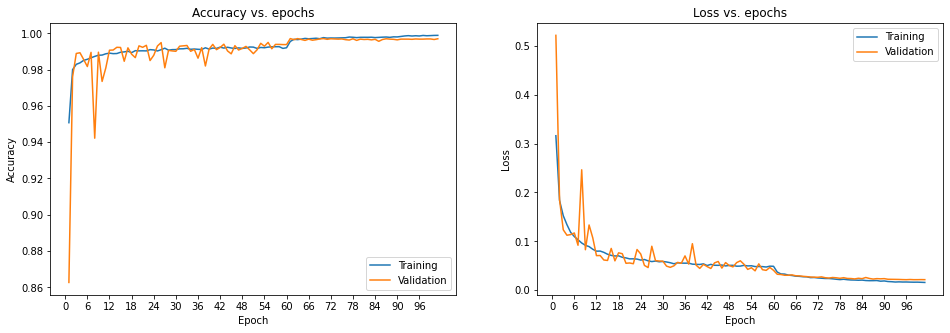

2021-08-10 18:49:46,224: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20
----------------------------------------evaluate----------------------------------------


2021-08-10 18:50:26,333: INFO: test loss:0.0326
2021-08-10 18:50:26,335: INFO: test accuracy:0.9971
2021-08-10 18:50:26,340: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/results.json
2021-08-10 18:50:26,342: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/results.json
2021-08-10 18:50:26,342: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 18:50:26,343: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 18:50:26,344: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 18:50:27,996: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator


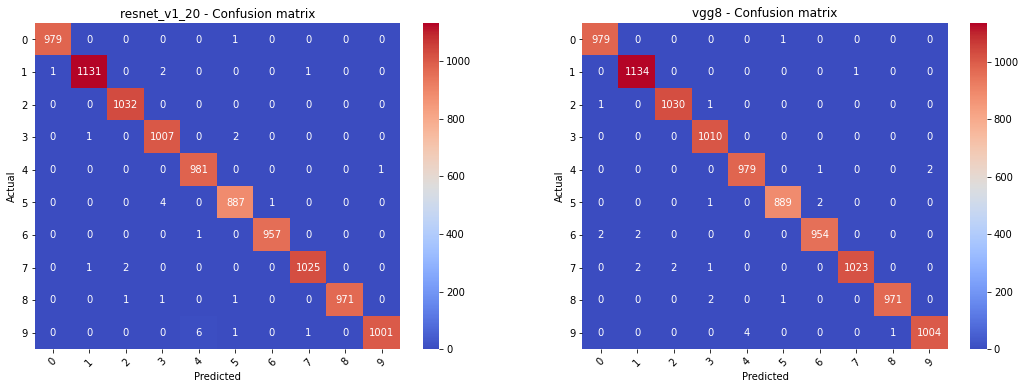

2021-08-10 18:50:33,513: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8


----------------------------------------sample analysis----------------------------------------


2021-08-10 18:50:35,186: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 18:50:35,190: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/custom1
2021-08-10 18:50:36,185: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 18:50:36,188: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/lenet1
2021-08-10 18:50:37,921: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 18:50:37,923: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-ten

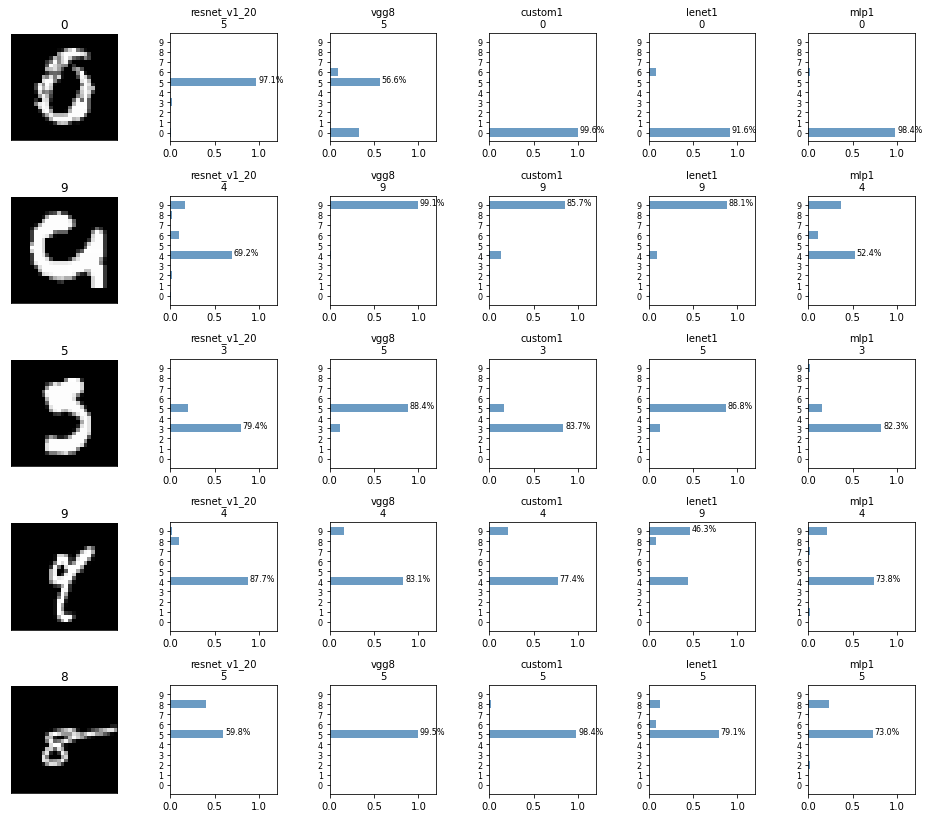

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,vgg8,1442378,2558.0,2021-08-10 17:22,0.0018,0.0109,0.9994,0.9973,1.0,1.0000
2,resnet_v1_20,272778,5213.4,2021-08-10 18:50,0.0297,0.0326,0.9980,0.9971,1.0,1.0000
3,custom1,73162,2222.3,2021-08-10 16:39,0.0046,0.0126,0.9987,0.9962,1.0,1.0000
4,lenet1,61750,2064.8,2021-08-10 16:01,0.0110,0.0150,0.9963,0.9951,1.0,1.0000
5,mlp1,101770,2681.3,2021-08-10 15:26,0.0183,0.0364,0.9945,0.9891,1.0,0.9999


In [22]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

## 评估

### 最佳模型

In [23]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

2021-08-10 18:50:45,241: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist
2021-08-10 18:50:45,243: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/results.json
2021-08-10 18:50:45,245: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/results.json


,model_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,vgg8,1442378,2558.0,2021-08-10 17:22,0.0018,0.0109,0.9994,0.9973,1.0,1.0000
2,resnet_v1_20,272778,5213.4,2021-08-10 18:50,0.0297,0.0326,0.9980,0.9971,1.0,1.0000
3,vgg8,1442378,2716.7,NaN,0.0001,0.0238,0.9999,0.9970,1.0,1.0000
4,custom1,73162,2222.3,2021-08-10 16:39,0.0046,0.0126,0.9987,0.9962,1.0,1.0000
5,lenet1,61750,1024.6,NaN,0.0015,0.0182,0.9996,0.9956,1.0,1.0000
6,resnet_v1_20,272778,5556.7,2021-08-10 11:27,0.0240,0.0395,0.9998,0.9952,1.0,1.0000
7,lenet1,61750,2064.8,2021-08-10 16:01,0.0110,0.0150,0.9963,0.9951,1.0,1.0000
8,custom1,73162,869.5,NaN,0.0026,0.0211,0.9992,0.9949,1.0,1.0000
9,mlp1,101770,2681.3,2021-08-10 15:26,0.0183,0.0364,0.9945,0.9891,1.0,0.9999
10,mlp1,101770,383.0,NaN,0.0030,0.0878,0.9996,0.9830,1.0,0.9996


2021-08-10 18:50:45,321: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/vgg8
2021-08-10 18:50:47,405: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 18:50:47,406: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/resnet_v1_20
2021-08-10 18:50:52,120: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100_aug/val_test.generator
2021-08-10 18:50:52,123: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8
2021-08-10 18:50:54,450: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_c

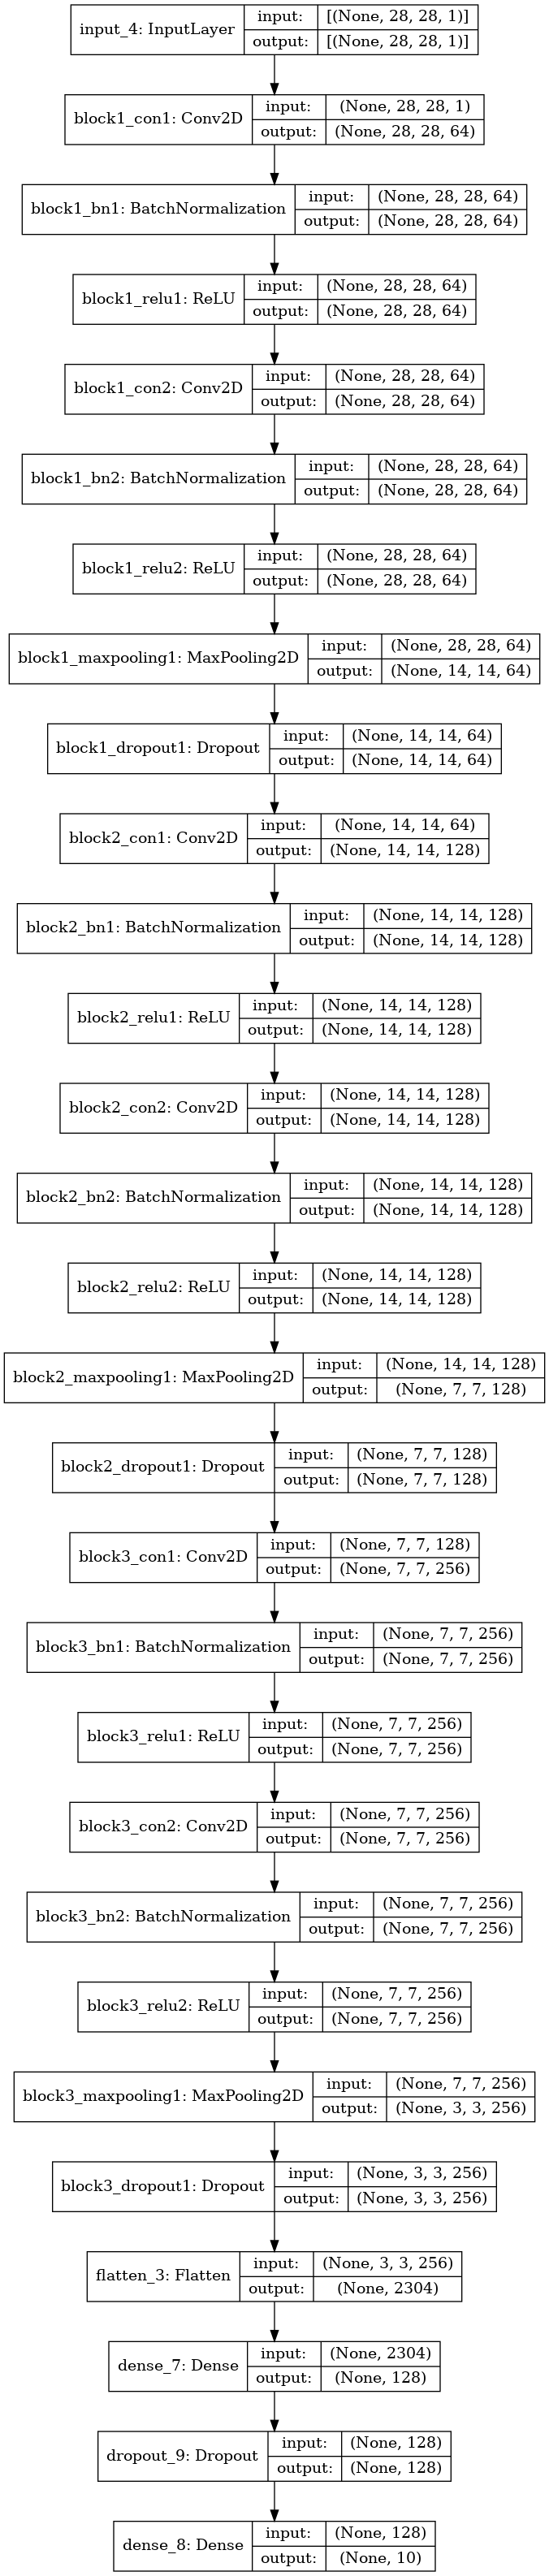

In [24]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

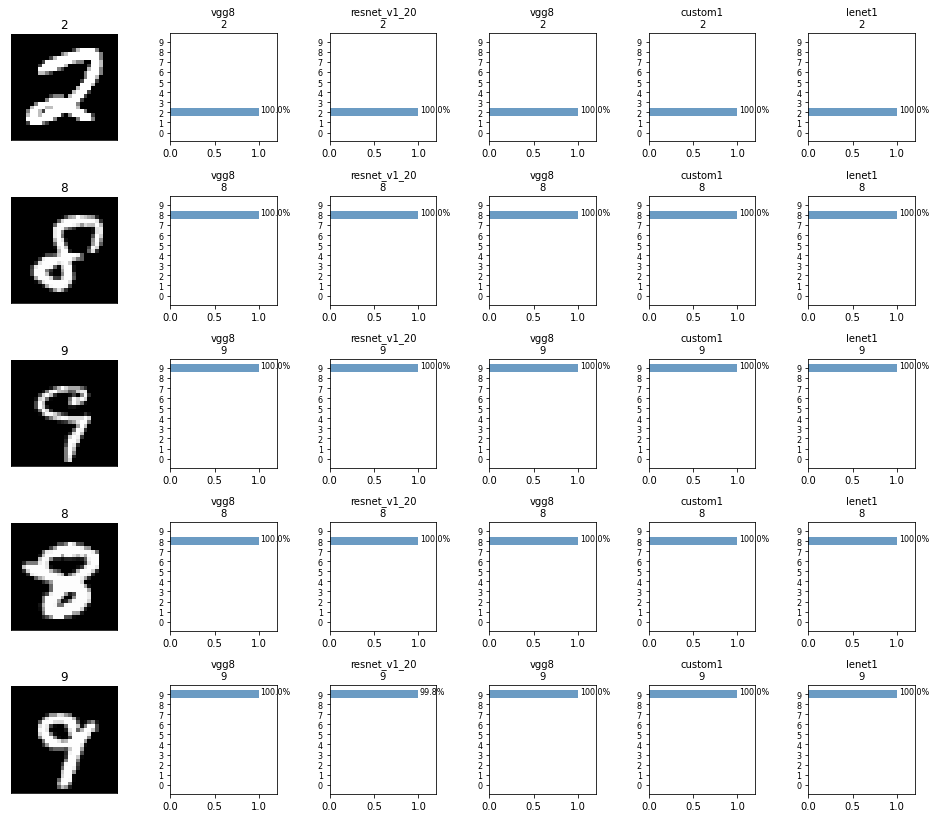

In [25]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

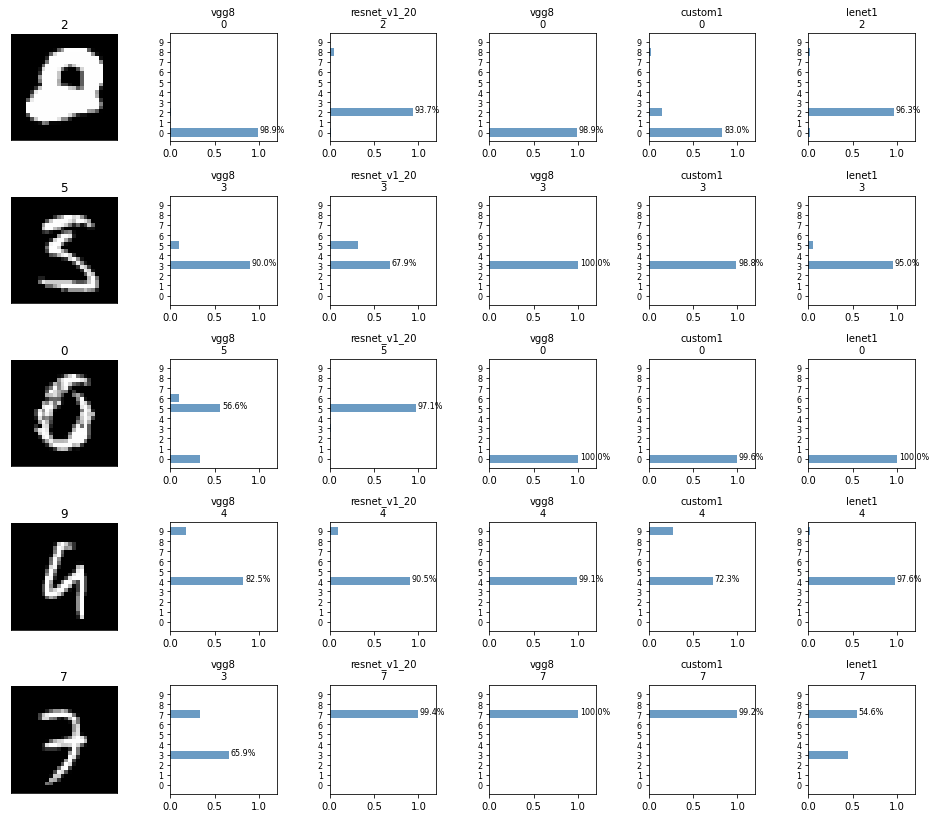

In [26]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### 评估

In [27]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

{'loss': 0.010929681360721588, 'accuracy': 0.9973000288009644, 'mae': 34.036048889160156}
(10000, 10)


In [28]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

,precision,recall,f1
0,0.996945,0.998980,0.997961
1,0.996485,0.999119,0.997800
2,0.998062,0.998062,0.998062
3,0.995074,1.000000,0.997531
4,0.995931,0.996945,0.996438
5,0.997755,0.996637,0.997196
6,0.996865,0.995825,0.996345
7,0.999023,0.995136,0.997076
8,0.998971,0.996920,0.997945
9,0.998012,0.995045,0.996526


----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.9969    0.9990    0.9980       980
           1     0.9965    0.9991    0.9978      1135
           2     0.9981    0.9981    0.9981      1032
           3     0.9951    1.0000    0.9975      1010
           4     0.9959    0.9969    0.9964       982
           5     0.9978    0.9966    0.9972       892
           6     0.9969    0.9958    0.9963       958
           7     0.9990    0.9951    0.9971      1028
           8     0.9990    0.9969    0.9979       974
           9     0.9980    0.9950    0.9965      1009

    accuracy                         0.9973     10000
   macro avg     0.9973    0.9973    0.9973     10000
weighted avg     0.9973    0.9973    0.9973     10000



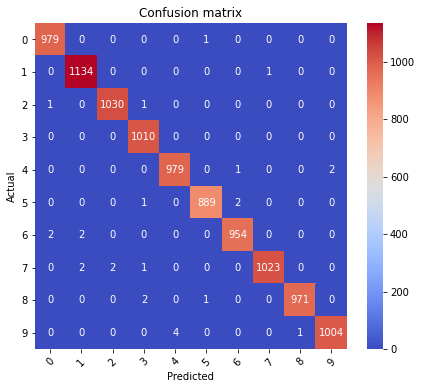

In [29]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)